In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F

In [2]:
with open('Key') as f:
    key = f.read()
symbol = 'AMD'
interval = '1min'

In [3]:
# api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&outputsize=full&apikey={key}'
api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={key}'

In [4]:
req = requests.get(api_call)

In [5]:
amd_ts = json.loads(req.text)

meta = amd_ts['Meta Data']

data = amd_ts['Time Series (Daily)']

amd_df = pd.DataFrame(data).T

In [6]:
col_name = {'1. open': 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'Close', '5. volume': 'Volume', 'index': 'Time'}
amd_df = amd_df.reset_index()
amd_df = amd_df.rename(columns=col_name)

amd_open = amd_df[['Time', 'Open']]
amd_open = amd_open.rename(columns={'Time':'ds', 'Open': 'y'})

In [7]:
class regressor(torch.nn.Module):
    def __init__(self):
        super(regressor, self).__init__()
        self.in_layer = nn.Linear(10, 32)
        self.layer_1 = nn.Linear(32, 16)
        self.layer_2 = nn.Linear(16, 4)
        self.output = nn.Linear(4, 1)
        
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x):
        x = self.in_layer(x)
        x = self.ReLU(x)
        x = self.layer_1(x)
        x = self.ReLU(x)
        x = self.layer_2(x)
        x = self.ReLU(x)
        x = self.output(x)
        return x

In [8]:
reg_net = regressor()
reg_net = reg_net.float()
optimizer = torch.optim.Adam(reg_net.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

In [9]:
# Create autoregressive dataset
dataset = pd.concat([amd_open[['y']].rename(columns={'y': f'x_{i}'}).shift(i) for i in range(1, 11)], axis=1)
dataset.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52.2803,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51.3400,52.2803,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
x = dataset.to_numpy()[10:].astype(np.double)
y = amd_open['y'].to_numpy()[10:].astype(np.double)

In [11]:
num_epochs = 1

In [12]:
for epoch in range(num_epochs):
    for xi, yi in zip(x, y):
        xt = torch.tensor(xi)
        yt = torch.tensor(yi)
        optimizer.zero_grad()
        estimate = reg_net(xt.float())
        loss = criterion(estimate, yt)
        loss.backward()
        optimizer.step()

C:\Users\silas\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [13]:
prediction = reg_net(torch.tensor(x).float())

In [14]:
pred = prediction.detach().numpy()

In [15]:
idx = list(amd_open['ds'])

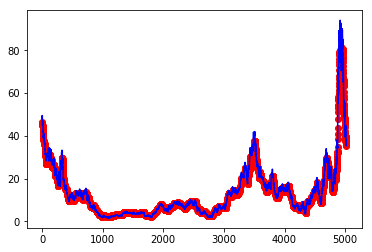

In [16]:
plt.plot(range(len(pred)), pred, 'ro')
plt.plot(range(len(y)), y, 'b')
plt.show()